<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Important-Scripts" data-toc-modified-id="Important-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Important Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Log-transform-large-values" data-toc-modified-id="Log-transform-large-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Log transform large values</a></span></li><li><span><a href="#Train-Test-split-after-log-transform" data-toc-modified-id="Train-Test-split-after-log-transform-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train-Test split after log transform</a></span></li><li><span><a href="#Scaling-the-Data" data-toc-modified-id="Scaling-the-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scaling the Data</a></span></li><li><span><a href="#GBR-Modelling" data-toc-modified-id="GBR-Modelling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>GBR Modelling</a></span></li><li><span><a href="#GBR-modelling-using-pipeline" data-toc-modified-id="GBR-modelling-using-pipeline-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>GBR modelling using pipeline</a></span></li><li><span><a href="#Cross-Validation-Results" data-toc-modified-id="Cross-Validation-Results-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Cross Validation Results</a></span></li><li><span><a href="#HPO-(Hyper-Parameters-Optimization)" data-toc-modified-id="HPO-(Hyper-Parameters-Optimization)-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>HPO (Hyper Parameters Optimization)</a></span><ul class="toc-item"><li><span><a href="#Grid-Search-for-Gradient-Boosting-Regressor" data-toc-modified-id="Grid-Search-for-Gradient-Boosting-Regressor-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Grid Search for Gradient Boosting Regressor</a></span></li><li><span><a href="#Best-Model" data-toc-modified-id="Best-Model-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Best Model</a></span></li></ul></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

This dataset contains house sale prices for King County,
which includes Seattle.
It includes homes sold between May 2014 and May 2015.

- Dependent features: 1 (price)
- Features : 19 home features
- Id:  1 house ID

Task: Try to estimate the price based on given features.

![](https://github.com/bhishanpdl/Project_House_Price_Prediction/blob/master/data/raw/data_description.png?raw=1)

# Imports

In [ ]:
import time
time_start_notebook = time.time()

In [ ]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install catboost
    !pip install shap eli5

    # if we update existing module, we need to restart colab
    !pip install -U scikit-learn

    ## print
    print('Environment: Google Colaboratory.')
TREE_METHOD = 'gpu_hist' if ENV_COLAB else 'auto'

In [ ]:
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
from pprint import pprint

# random state
SEED=100
np.random.seed(SEED)

# settings
pd.set_option('display.max_columns', 200)

# sklearn
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# boosting
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost
import lightgbm
import catboost

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-11-05 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

matplotlib 3.2.2
xgboost    0.90
numpy      1.18.5
lightgbm   2.2.3
pandas     1.1.4
sklearn    0.23.2
watermark  2.0.2
catboost   0.24.2
seaborn    0.11.0



# Important Scripts

In [ ]:
def show_methods(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [ ]:
def adjustedR2(rsquared,nrows,ncols):
    return rsquared- (ncols-1)/(nrows-ncols) * (1-rsquared)

In [ ]:
def print_regr_eval(ytest,ypreds,ncols):
    rmse = np.sqrt(metrics.mean_squared_error(ytest,ypreds))
    r2 = metrics.r2_score(ytest,ypreds)
    ar2 = adjustedR2(r2,len(ytest),ncols)
    evs = metrics.explained_variance_score(ytest, ypreds)

    print(f"""
             RMSE : {rmse:,.2f}
Explained Variance: {evs:.6f}
         R-Squared: {r2:,.6f}
Adjusted R-squared: {ar2:,.6f}

""")

In [ ]:
  
def plot_xgb_cv_res(df_cv_results):
    fig,ax = plt.subplots()
    plt.plot(df_cv_results['train-rmse-mean'],color='b',label='train-rmse')
    plt.plot(df_cv_results['test-rmse-mean'],color='r',label='train-rmse')
    plt.title('Cross validation score mean plot',fontsize=14)
    plt.legend()
    plt.show()

# Parameters

In [ ]:
if ENV_COLAB:
    path_raw = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/'
    proj = 'Projects/King_County_Seattle_House_Price_Kaggle/'
    data_path_parent = path_raw + proj
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

else:
    data_path_parent = '../data/'
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

target = 'price'
train_size = 0.8

print(data_path_train)

https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/King_County_Seattle_House_Price_Kaggle/raw/train.csv


# Load the data

In [ ]:
df_train_raw = pd.read_csv(data_path_train)
df_test_raw = pd.read_csv(data_path_test)
print(df_train_raw.shape)
print(df_train_raw.columns)

display(df_train_raw.head(2).append(df_train_raw.tail(2)))

(17290, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2561340020,20140804T000000,325000.0,3,1.75,1780,11096,1.0,0,0,3,7,1210,570,1979,0,98074,47.6170,-122.051,1780,10640
1,8598200070,20141208T000000,278000.0,2,2.50,1420,2229,2.0,0,0,3,7,1420,0,2004,0,98059,47.4871,-122.165,1500,2230
17288,7174800760,20140725T000000,667000.0,5,2.00,1900,5470,1.0,0,0,3,7,1180,720,1930,1965,98105,47.6666,-122.303,1300,3250
17289,9521100280,20140612T000000,480000.0,3,2.50,1250,1103,3.0,0,2,3,8,1250,0,2005,0,98103,47.6619,-122.352,1250,1188


# Data Processing

In [ ]:
def clean_data(df):
    df = df.copy()

    # Date time features
    df['date'] = pd.to_datetime(df['date'])
    df['yr_sales'] = df['date'].dt.year
    df['age'] = df['yr_sales'] - df['yr_built']
    df['yr_renovated2'] = np.where(df['yr_renovated'].eq(0), df['yr_built'], df['yr_renovated'])
    df['age_after_renovation'] = df['yr_sales'] - df['yr_renovated2']

    # Categorical Features
    cols_str = ['waterfront', 'view', 'condition', 'grade','zipcode']
    for c in cols_str:
        df[c] = df[c].astype(str)

    cols_obj = df.select_dtypes(['object','category']).columns
    cols_obj_small = ['waterfront', 'view', 'condition', 'grade']

    # Boolean data types
    df['basement_bool'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)
    df['renovation_bool'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

    # Numerical features binning
    cols_bin = ['age','age_after_renovation']
    df['age_cat'] = pd.cut(df['age'], 10, labels=range(10)).astype(str)
    df['age_after_renovation_cat'] = pd.cut(df['age_after_renovation'], 10, labels=range(10))

    # Create dummy variables from object and categories
    cols_obj_cat = df.select_dtypes(include=[np.object, 'category']).columns
    cols_dummy = ['waterfront', 'view', 'condition', 'grade',
                'age_cat', 'age_after_renovation_cat']

    df_dummy = pd.get_dummies(df[cols_dummy],drop_first=False)
    df = pd.concat([df,df_dummy], axis=1)

    # after creating dummy, make the columns number
    for c in cols_obj_cat:
        df[c] = df[c].astype(np.int8)

    # Log transformation of large numerical values
    cols_log = ['sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']

    for col in cols_log:
        df['log1p_' + col] = np.log1p(df[col])

    # squared columns
    cols_sq = [
        # cats
        'bedrooms','bathrooms','floors','waterfront','view',

        # nums
        'age','age_after_renovation',

        # log nums
        'log1p_sqft_living','log1p_sqft_lot',
        'log1p_sqft_above','log1p_sqft_basement',
        'log1p_sqft_living15','log1p_sqft_lot15'
        ]
    for col in cols_sq:
        df[col + '_sq'] = df[col]**2

    # Drop unwanted columns
    cols_drop = ['id','date']
    df = df.drop(cols_drop,axis=1)

    return df

In [ ]:
df_train = clean_data(df_train_raw)
df_test = clean_data(df_test_raw)

print(df_train.shape)
print(df_train.columns)

(17290, 90)
Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'yr_sales', 'age', 'yr_renovated2',
       'age_after_renovation', 'basement_bool', 'renovation_bool', 'age_cat',
       'age_after_renovation_cat', 'waterfront_0', 'waterfront_1', 'view_0',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_1', 'condition_2',
       'condition_3', 'condition_4', 'condition_5', 'grade_1', 'grade_10',
       'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'age_cat_0', 'age_cat_1',
       'age_cat_2', 'age_cat_3', 'age_cat_4', 'age_cat_5', 'age_cat_6',
       'age_cat_7', 'age_cat_8', 'age_cat_9', 'age_after_renovation_cat_0',
       'age_after_renovation_cat_1', 'age_after_renovation_cat_2',
       'age_after_

In [ ]:
# df_train.dtypes.to_numpy()

In [ ]:
# make sure no data leakage
df_train.filter(regex='price').columns

Index(['price'], dtype='object')

In [ ]:
# make sure no nans
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

# Train target split

In [ ]:
# choose features to train, we can change it later
features = list(sorted(df_train.columns.drop(target)))
# print(np.array(features))

In [ ]:
features = [i for i in features if i in df_test.columns if i in df_train.columns]
# print(np.array(sorted(features)))

In [ ]:
df_Xtrain  = df_train[features]
ser_ytrain = df_train[target]

df_Xtest  = df_test[features]
ser_ytest = df_test[target]

ytrain = np.array(ser_ytrain).flatten()
ytest  = np.array(ser_ytest).flatten()

## Scaling

In [ ]:
scaling = 'standard'
if scaling == 'standard':
    scaler = preprocessing.StandardScaler()
    scaler.fit(df_Xtrain)
    df_Xtrain = pd.DataFrame(scaler.transform(df_Xtrain),columns=features)
    df_Xtest =  pd.DataFrame(scaler.transform(df_Xtest),columns=features)
elif scaling == 'minmax':
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df_Xtrain)
    df_Xtrain = pd.DataFrame(scaler.transform(df_Xtrain),columns=features)
    df_Xtest = pd.DataFrame(scaler.transform(df_Xtest),columns=features)


df_Xtrain.head(2)

,age,age_after_renovation,age_after_renovation_cat,age_after_renovation_cat_0,age_after_renovation_cat_1,age_after_renovation_cat_2,age_after_renovation_cat_3,age_after_renovation_cat_4,age_after_renovation_cat_5,age_after_renovation_cat_6,age_after_renovation_cat_7,age_after_renovation_cat_8,age_after_renovation_cat_9,age_after_renovation_sq,age_cat,age_cat_0,age_cat_1,age_cat_2,age_cat_3,age_cat_4,age_cat_5,age_cat_6,age_cat_7,age_cat_8,age_cat_9,age_sq,basement_bool,bathrooms,bathrooms_sq,bedrooms,bedrooms_sq,condition,condition_1,condition_2,condition_3,condition_4,condition_5,floors,floors_sq,grade,grade_10,grade_11,grade_12,grade_13,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,lat,log1p_sqft_above,log1p_sqft_above_sq,log1p_sqft_basement,log1p_sqft_basement_sq,log1p_sqft_living,log1p_sqft_living15,log1p_sqft_living15_sq,log1p_sqft_living_sq,log1p_sqft_lot,log1p_sqft_lot15,log1p_sqft_lot15_sq,log1p_sqft_lot_sq,long,renovation_bool,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,view_0,view_1,view_2,view_3,view_4,view_sq,waterfront,waterfront_0,waterfront_1,waterfront_sq,yr_built,yr_renovated,yr_renovated2,yr_sales,zipcode
0,-0.288109,-0.212303,-0.062185,-0.459574,-0.415931,-0.380633,2.608131,-0.406415,-0.350429,-0.236658,-0.224556,-0.202644,-0.181261,-0.438016,-0.139825,-0.435083,-0.396508,-0.367269,2.611511,-0.412577,-0.364526,-0.249992,-0.237882,-0.219826,-0.196057,-0.494698,1.247166,-0.468811,-0.537610,-0.39033,-0.302220,-0.630613,-0.035694,-0.08937,0.735526,-0.595921,-0.294513,-0.916249,-0.837904,-0.554878,-0.238288,-0.135782,-0.066005,-0.026354,-0.036497,-0.108453,-0.324043,1.186907,-0.624934,-0.367371,0.410048,-0.688967,-0.698830,1.208375,1.137983,-0.149505,-0.169074,-0.189252,-0.177052,0.361630,0.383984,0.328910,0.301512,1.151178,-0.207998,-0.698239,0.636923,-0.322100,-0.302502,-0.095727,-0.078695,-0.305512,0.329787,-0.123077,-0.217065,-0.1533,-0.124282,-0.261712,-0.089698,0.089698,-0.089698,-0.089698,0.277141,-0.207992,0.201159,-0.693043,0.190991
1,-1.135161,-1.074946,-1.265291,2.175927,-0.415931,-0.380633,-0.383416,-0.406415,-0.350429,-0.236658,-0.224556,-0.202644,-0.181261,-0.814627,-1.320662,2.298413,-0.396508,-0.367269,-0.382920,-0.412577,-0.364526,-0.249992,-0.237882,-0.219826,-0.196057,-0.856409,-0.801818,0.506258,0.326221,-1.46038,-0.775165,-0.630613,-0.035694,-0.08937,0.735526,-0.595921,-0.294513,0.933474,0.806845,-0.554878,-0.238288,-0.135782,-0.066005,-0.026354,-0.036497,-0.108453,-0.324043,1.186907,-0.624934,-0.367371,-0.527440,-0.314663,-0.338123,-0.795545,-0.779839,-0.681826,-0.692075,-0.700087,-0.697163,-1.411647,-1.527957,-1.398248,-1.291600,0.344386,-0.207998,-0.442941,-0.658262,-0.716449,-0.712318,-0.302804,-0.378759,-0.305512,0.329787,-0.123077,-0.217065,-0.1533,-0.124282,-0.261712,-0.089698,0.089698,-0.089698,-0.089698,1.124268,-0.207992,1.064027,-0.693043,-0.077129



# Modelling: xgboost
https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
```python
Parameters:
-------------
max_depth=3
learning_rate=0.1
n_estimators=100 # number of trees you want to build.
verbosity=1 **NOTE: it print in ipython terminal not in browser
silent=None **deprecated use verbosity
objective='binary:logistic' **for binary classification
booster='gbtree' **use default tree not linear even for regression (may also use dart instead of gbtree, but needs to tune)
n_jobs=1 **make this -1
nthread=None **deprecated use n_jobs
gamma=0 # A higher value leads to fewer splits.
min_child_weight=1
max_delta_step=0
subsample=1 # percentage of samples used per tree. Low value can lead to underfitting.
colsample_bytree=1 # percentage of features used per tree. High value can lead to overfitting.
colsample_bylevel=1
colsample_bynode=1
reg_alpha=0 # A large value leads to more regularization.
reg_lambda=1 # L2 regularization on leaf weights and is smoother than L1 regularization.
scale_pos_weight=1
base_score=0.5
random_state=0 **use your own random state
seed=None      **deprecated use random_state
missing=None
```

[Early stopping](https://xgboost.readthedocs.io/en/latest/python/python_intro.html):  

If you have a validation set, you can use early stopping to find the optimal number of boosting rounds. Early stopping requires at least one set in evals. If there’s more than one, it will use the last.

`train(..., evals=evals, early_stopping_rounds=10)`


The model will train until the validation score stops improving. Validation error needs to decrease at least every early_stopping_rounds to continue training.

If early stopping occurs, the model will have three additional fields: `bst.best_score`, `bst.best_iteration` and `bst.best_ntree_limit`. Note that xgboost.train() will return a model from the last iteration, not the best one.

This works with both metrics to minimize (RMSE, log loss, etc.) and to maximize (MAP, NDCG, AUC). Note that if you specify more than one evaluation metric the last one in param['eval_metric'] is used for early stopping.

If early stopping is enabled during training, you can get predictions from the best iteration with bst.best_ntree_limit:

`ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)`



[Faster implementations](https://github.com/dmlc/xgboost/issues/1950)

Flexible tree growing policies
The existing tree grower in xgboost grows a tree in a depth-wise fashion, executing splits in first level before splits in second and so forth. The new grower lets you control the way new nodes are added to the tree:

grow_policy=depthwise (default): split at nodes closest to the root, i.e. grow depth-wise.
grow_policy=lossguide: split at nodes with highest loss change. This behavior mimics that of LightGBM.
It has been reported that the lossguide policy often results in faster convergence in loss, though there is also risk of over-fitting(see the preliminary results).


In [ ]:
model = xgboost.XGBRegressor(n_jobs=-1, random_state=SEED,
                        objective='reg:squarederror')

model.fit(df_Xtrain, ytrain)

ypreds = model.predict(df_Xtest)
print_regr_eval(ytest,ypreds,df_Xtest.shape[1])


             RMSE : 132,796.81
Explained Variance: 0.869266
         R-Squared: 0.869147
Adjusted R-squared: 0.866490




## cross validation

In [ ]:
%%time
scoring = "neg_mean_squared_error"
kf = model_selection.KFold(5,shuffle=True,random_state=SEED)
cvs = model_selection.cross_val_score(model, df_Xtrain, ytrain,cv=kf,
                      scoring = scoring)
score = cvs.mean()
score_std = cvs.std()
print(f"{scoring}: {score:,.2f}\n std : {score_std:,.2f}")

neg_mean_squared_error: -19,107,513,744.43
 std : 2,731,463,865.97
CPU times: user 24.2 s, sys: 40.6 ms, total: 24.3 s
Wall time: 12.3 s


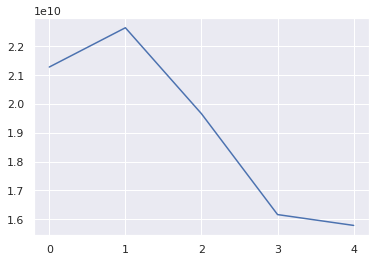

In [ ]:
plt.plot(cvs*-1)
plt.xticks(range(len(cvs)))
plt.show()

## cross validation using xgboost.cv with dtrain
- Using xgb.cv needs xgboost dataset matrix not numpy or pandas.
- xgb DMatrix uses much less memory than pandas dataframe.

In [ ]:
%%time

dtrain = xgboost.DMatrix(df_Xtrain,ytrain,
                     feature_names=features)
params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5,
          'alpha': 10}

num_boost_round=500
kf=model_selection.KFold(n_splits=5,shuffle=True,random_state=SEED)

# we need xgb data matrix to use xgboost api of xgboost.cv
df_cv_results = xgboost.cv(params,dtrain, num_boost_round,
                    nfold=5,
                    early_stopping_rounds=50,
                    metrics="rmse",
                    folds=kf,
                    verbose_eval=50, # show progress at Nth iteration
                    seed=SEED)

display(df_cv_results.head())

[0]	train-rmse:595968+3797.34	test-rmse:596519+15742
[50]	train-rmse:107862+1595.01	test-rmse:139157+10296.2
[100]	train-rmse:88707.2+565.805	test-rmse:127920+10604.5
[150]	train-rmse:79450.5+682.136	test-rmse:124030+9982.81
[200]	train-rmse:73126.2+642.893	test-rmse:122217+10017.2
[250]	train-rmse:68622.9+563.235	test-rmse:121246+10091.8
[300]	train-rmse:64985.5+451.971	test-rmse:120584+10226.2
[350]	train-rmse:61793.1+359.358	test-rmse:119870+10086.1
[400]	train-rmse:59022.1+319.119	test-rmse:119607+10013.8
[450]	train-rmse:56496.7+368.737	test-rmse:119214+9926.2
[499]	train-rmse:54307.6+336.22	test-rmse:118906+9895.94


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,595967.71250,3797.337843,596519.36250,15741.976944
1,545303.13750,3119.912589,546501.26250,16215.489025
2,500045.91250,2822.529867,501948.96875,16169.032656
3,458778.48750,3044.784519,461701.25000,15915.449404
4,421874.45625,3202.837791,425820.86875,15424.145148


CPU times: user 1min 40s, sys: 267 ms, total: 1min 40s
Wall time: 50.9 s


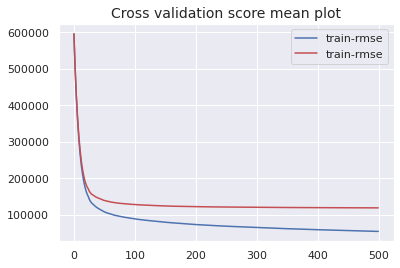

In [ ]:
plot_xgb_cv_res(df_cv_results)

# Best Model

In [ ]:
%%time
params_xgb = dict(n_jobs=-1, random_state=SEED,
                        objective='reg:squarederror',
                        n_estimators=1200,
                        max_depth=3,
                        reg_alpha=1,
                        reg_lambda=5,
                        subsample=1,
                        gamma=0,
                        min_child_weight=1,
                        colsample_bytree=1,
                        learning_rate=0.1
                        )

model = xgboost.XGBRegressor(**params_xgb)
model.fit(df_Xtrain,ytrain)

ypreds = model.predict(df_Xtest)
print_regr_eval(ytest,ypreds,df_Xtest.shape[1])


             RMSE : 114,778.62
Explained Variance: 0.902313
         R-Squared: 0.902247
Adjusted R-squared: 0.900262


CPU times: user 1min 9s, sys: 72.1 ms, total: 1min 9s
Wall time: 35.2 s


## Log transform the target

In [ ]:
%%time
ytrain_log1p = np.log1p(ytrain)

model = xgboost.XGBRegressor(n_jobs=-1, random_state=SEED, **params_xgb)
model.fit(df_Xtrain, ytrain_log1p)

ypreds_log1p = model.predict(df_Xtest)
ypreds = np.expm1(ypreds_log1p)

print('ytest:', ytest[:3])
print('ypreds: ', ypreds[:3])
print_regr_eval(ytest,ypreds,df_Xtest.shape[1])

TypeError: ignored

## Feature importance

In [ ]:
# feature importance
df_imp = pd.DataFrame({'Feature': features,
                       'Importance_gain': model.feature_importances_
                       }) 

df_imp.nlargest(10,'Importance_gain').style.background_gradient()

In [ ]:
(df_imp
 .set_index('Feature')
 .nlargest(10,'Importance_gain')
 .plot
 .barh(figsize=(12,8))
 .invert_yaxis()
)

In [ ]:
show_methods(model,5)

In [ ]:
bst = model.get_booster()
bst

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
xgboost.plot_tree(bst,ax=ax,num_trees=4)

In [ ]:
# help(xgboost.plot_importance)

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
xgboost.plot_importance(bst,ax=ax,importance_type='weight',max_num_features=20)
plt.show()

## Feature selection using permutation feature importance
- [sklearn: inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)
- [sklearn: permutation plot](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)

In [ ]:
from sklearn.inspection import permutation_importance
# permutation_importance?

In [ ]:
Xtr,Xvd,ytr,yvd = model_selection.train_test_split(df_Xtrain,ytrain,
                                        train_size=0.8,random_state=SEED)

In [ ]:
%%time
model = xgboost.XGBRegressor(**params_xgb)
model.fit(Xtr,ytr)

perm_imp = permutation_importance(model, Xvd, yvd,
                           n_repeats=20,
                           n_jobs=-1,
                           random_state=SEED)
        

CPU times: user 56.9 s, sys: 170 ms, total: 57.1 s
Wall time: 3min 19s


In [ ]:
df_perm_imp = pd.DataFrame({
    'importances_mean': abs(perm_imp.importances_mean),
    'importance_std': perm_imp.importances_std
},index=features)

df_perm_imp = df_perm_imp.sort_values('importances_mean',ascending=False)

df_perm_imp.head(10)

,importances_mean,importance_std
lat,0.297136,0.011919
grade,0.170656,0.006471
log1p_sqft_living,0.156866,0.003552
long,0.117675,0.011006
log1p_sqft_living15,0.035709,0.001395
log1p_sqft_lot,0.029160,0.001397
log1p_sqft_above,0.023686,0.001465
waterfront,0.021518,0.001149
zipcode,0.021361,0.001864
view,0.016140,0.001022


In [ ]:
df_perm_imp.tail()

,importances_mean,importance_std
log1p_sqft_basement_sq,0.0,0.0
log1p_sqft_living15_sq,0.0,0.0
log1p_sqft_living_sq,0.0,0.0
log1p_sqft_lot15_sq,0.0,0.0
grade_13,0.0,0.0


In [ ]:
features_sel = df_perm_imp.query("importances_mean > 0.00").index.to_numpy()
print(features_sel)
features_sel = list(features_sel)

['lat' 'grade' 'log1p_sqft_living' 'long' 'log1p_sqft_living15'
 'log1p_sqft_lot' 'log1p_sqft_above' 'waterfront' 'zipcode' 'view'
 'bathrooms' 'log1p_sqft_basement' 'condition' 'age' 'yr_sales'
 'age_after_renovation' 'yr_built' 'log1p_sqft_lot15' 'bedrooms' 'floors'
 'yr_renovated2' 'grade_10' 'yr_renovated' 'age_after_renovation_cat_4'
 'grade_7' 'condition_4' 'grade_9' 'view_3' 'grade_12' 'grade_11'
 'age_cat_5' 'renovation_bool' 'age_after_renovation_cat_1' 'age_cat_2'
 'age_after_renovation_cat_8' 'basement_bool' 'condition_3'
 'age_after_renovation_cat_2' 'age_after_renovation_cat_7' 'age_cat_4'
 'grade_8' 'age_cat_1' 'age_cat_3' 'grade_6' 'age_after_renovation_cat_3'
 'age_after_renovation_cat_5' 'view_2' 'age_cat_6' 'view_1' 'condition_2'
 'grade_4' 'age_cat_8' 'age_cat_7']


In [ ]:
%%time
model = xgboost.XGBRegressor(**params_xgb)
model.fit(df_Xtrain[features_sel],ytrain)
ypreds = model.predict(df_Xtest[features_sel])

print_regr_eval(ytest,ypreds,len(features_sel))


             RMSE : 117,957.46
Explained Variance: 0.896851
         R-Squared: 0.896757
Adjusted R-squared: 0.895500


CPU times: user 45.1 s, sys: 92 ms, total: 45.2 s
Wall time: 22.9 s


<div class="alert alert-block alert-danger">

<font color='red'>WARNING:</font>
</br>
Feature Selection using feature importance > 0 gave me worse results
for this dataset.

</div>

# Time Taken

In [ ]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 17 min 3 secs
